<div align="center"><h1>Control Engineering Basics</h1>
<br><b>Dr.Varodom Toochinda</b>
<br>Dept. of Mechanical Engineering, Kasetsart University</div>

<a href="https://colab.research.google.com/github/dewdotninja/control_python/blob/master/ceb_m5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Module 5: State Feedback

<b>Requirement : </b> Python 3 with Python control systems library
<p />Execute the commands below to install Python control systems library in Colab    


In [ ]:
!pip install control

This article is contained in Control Engineering Basics study module, which is used as course material for Electrical-Mechanical Manufacturing Engineering (EMME), Department of Mechanical Engineering, Kasetsart University.

### Module Key Study Points
* Understand state-space representation of a system
* How to convert data between state-space and transfer function form
* Design state feedback using simple pole-placement procedure
* Append an integrator to state feedback to eliminate steady-state error

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl

<p />State feedback control, the topic of this study module, can be thought of as a foundation for the so-called 
<em>“modern control”</em>(*) originated since ’60.  In contrast to the frequency domain analysis of the classical 
control theory, modern control theory formulates the time-domain data as a system of first-order differential 
equations in matrix form called <em>state-space representation</em>, which is a mathematical model of the given 
system as a set of input, output, and state variable. 

***
<p />(*) This terminology is commonly used in the control literature, regardless of calling a 50-year-old approach 
modern could sometimes create confusion to a beginner. Indeed, the modern control approach is so eternal that  
later developments have to be called <em>post-modern.</em>

***
<p />First, we give some review on state-space representation, which is essential for the state feedback design 
discussed later on. Let us take our simple DC motor joint model as an example. A dynamic equation that governs the 
motion can be written as

\begin{equation} 
J\ddot{\theta}(t) + B\dot{\theta}(t) = u(t)
\end{equation}
<div align="right">(1)</div>

<p />To simplify the notation, the time dependent is omitted. Define the system states as the joint position and velocity
\begin{eqnarray}
x_1 = \theta  \\
x_2 = \dot{\theta}
\end{eqnarray}
<div align="right">(2)</div>

<p />By using these state variables, (1) can be rewritten as a system of first order differential equations
\begin{eqnarray}
\dot{x}_1 &=& x_2  \\
\dot{x}_2 &=& -\frac{B}{J}x_2 + \frac{1}{J}u(t)
\end{eqnarray}
<div align="right">(3)</div>

<p />or in matrix form as

\begin{equation} 
\left[ \begin{array}{c}
\dot{x}_1 \\
\dot{x}_2 
\end{array}  \right] = 
\left[ \begin{array} {cc}
0 & 1 \\
0 & -\frac{B}{J}
\end{array} \right]
\left[ \begin{array}{c}
x_1 \\
x_2
\end{array} \right] + 
\left[ \begin{array}{c}
0 \\
\frac{1}{J} 
\end{array} \right] u
\end{equation}
<div align="right">(4)</div>

<p />and the output equation, with $y = \theta$

\begin{equation} 
y = \left[ \begin{array}{cc}
1 & 0
\end{array} \right] \left[ \begin{array}{c}
x_1 \\
x_2
\end{array} \right]
\end{equation}
<div align="right">(5)</div>

<p />In general, a linear time-invariant (LTI) system can be described as

\begin{equation} 
\dot{x} = Ax + Bu
\end{equation}
<div align="right">(6)</div>

\begin{equation} 
y = Cx + Du
\end{equation}
<div align="right">(7)</div>

<p />where $x,u,y$ represent the state, input, and output vectors, respectively.  (6) is called a 
<em>state equation</em>, and (7) an <em>output equation</em>. Note that this representation is not unique, 
but depends on how the states are defined. Moreover, though in our robot joint example the states are conveniently 
joint position and velocity, for the general case the states might not have any physical meaning, and hence could 
not be measured. 

<p />For a system represented by (6) and (7), it is easy to show that the corresponding transfer function equals

\begin{equation} 
P(s) = C(sI - A)^{-1}B + D
\end{equation}
<div align="right">(8)</div>

<p />To convert between state space and transfer function with Python Control library, use ss2tf() and tf2ss(). 
For example, for a plant transfer function 

$$
P(s) = \frac{1}{10s^2 + 0.1s}
$$ 

In [3]:
s = ctl.tf('s')
P = 1/(10*s**2+0.1*s)
P

TransferFunction(array([1]), array([10. ,  0.1,  0. ]))

This can be converted to state-space form by

In [4]:
Pss = ctl.tf2ss(P)

Verify whether the  matrices conform to (4) 

In [5]:
A,B,C,D = ctl.ssdata(Pss)
print("A = {}".format(A))
print("B = {}".format(B))
print("C = {}".format(C))
print("D = {}".format(D))

A = [[-0.01 -0.  ]
 [ 1.    0.  ]]
B = [[1.]
 [0.]]
C = [[0.  0.1]]
D = [[0.]]


Interestingly, they look different! This is due to the order the state vector. The software assigns it as 
$x = [x_1, x_2]^T = [\dot{\theta}, \theta]^T$.

This result reveals that state-space representation is not unique.

To convert back to transfer function, use ss2tf() function. We see that some normalization is applied such that the 
coefficient of highest order of $s$ in the denominator is one.

In [6]:
P1 = ctl.ss2tf(Pss)
P1

TransferFunction(array([-1.73472348e-18,  1.00000000e-01]), array([1.  , 0.01, 0.  ]))

<p />Note that a transfer function for a physical system must be strictly proper; i.e., its frequency response must go to
zero as the frequency approaches infinity. (No system could have unlimited bandwidth in reality.) This implies its state-space 
representation must have zero $D$ matrix. 

<h3> State Feedback Control</h3>

<p />Obviously, a state feedback control is feasible in practice when all states are measurable, such as the robot joint 
dynamics in (4) with joint position and velocity as state variables. State feedback design can be performed with a scheme 
known as <em>pole placement</em>, or more systematic way using <em>Ackerman’s formula</em>. 

<p />The idea of pole placement is simple. Specify pole locations of the closed-loop system that yields desired stability
and performance criteria, for instance, in some shaded area shown in Figure 1. Then choose the state feedback control gains 
to move the closed-loop poles to such locations. A necessary condition is that the plant must be stabilizable. 
The details can be studied from most undergraduate control textbooks. 

<p align="center">
<img src="https://drive.google.com/uc?id=1OIVp0VUnhaXckVQufic17-aA13A-8DwK" width=350 alt="Figure 1"/>
</p>
<div align="center"><b>Figure 1 desired closed-loop pole locations</b></div>

<p />The state feedback controller is simply a vector of gains $K = \left[k_1,  k_2,  \ldots , k_n \right]^T$ connecting 
the states  to the plant input. So, for a set of specified closed-loop poles, the design goal is to 
compute $k_i, i = 1, \ldots ,n$  . 

Assume for the moment that the command input is zero. As shown in Figure 2, we have at the plant input

<p align="center">
<img src="https://drive.google.com/uc?id=14Mok9cUbcqwNSCNjo1TMrSJLX2jJHsJf" width=350 alt="Figure 2"/>
</p>
<div align="center"><b>Figure 2 block diagram of state feedback control</b></div>

\begin{equation} 
u = -Kx
\end{equation}
<div align="right">(9)</div>

<p />and the closed-loop state equation

\begin{equation} 
\dot{x} = (A - BK)x
\end{equation}
<div align="right">(10)</div>

<p />The closed-loop poles can be computed from

\begin{equation} 
det(sI - A + BK) = 0
\end{equation}
<div align="right">(11)</div>

<p />Meanwhile, specifying the closed-loop poles $p_i, i = 1, \ldots , n$ yields the characteristic polynomial

\begin{equation} 
\alpha(s) = (s - p_1)(s - p_2) \ldots (s - p_n)
\end{equation}
<div align="right">(12)</div>

<p />Hence, we can compare (11) and (12) to solve for $K$ manually,  which could be tedious for higher order equations.
Python control library provides a convenient function place() to solve for $K$, given the $A, B$ matrices and a 
vector of desired poles as arguments.

<p /><b>Example 1: </b>Let us design a state feedback control for the simple robot joint described by (4), (5) 
with $J = 10, B = 0.1$. Specify the desired properties of closed-loop system as follows:

<ol>
<li>overshoot less than 5%</li>
<li>rise time less than 0.1 sec</li>
</ol>

<p />By standard analysis of 2nd order system, we have that the specification 1 translates to damping ratio
$\zeta \ge 0.7$, and using the relation $t_r = 1.8/\omega_n$ , we have for specification 2 that $\omega_n \ge 18 $ rad/s..  
Substituting these two values to the closed-loop characteristic polynomials yields 

\begin{equation} 
\Lambda(s) = s^2 + 2\zeta\omega_ns + \omega_n^2 = s^2 + 25.2s + 324
\end{equation}
<div align="right">(12)</div>

<p />with poles at $-12.6 \pm 12.8546i$. The above procedure can be carried out by the following code

In [7]:
zeta = 0.7
wn = 18
lamda_s = s**2 + 2*zeta*wn*s+wn**2
desired_poles = ctl.zero(lamda_s) # poles are roots of characteristic polynomial
print(desired_poles)

[-12.6+12.85457117j -12.6-12.85457117j]


Construct the plant. It can be created in transfer function form first and converted to state-space. For this problem, we
choose to create the $A, B, C, D$ matrix directly using (4),(5), to make sure that the state vector is ordered as in (2). 

In [8]:
A = np.array([[0.,  1.  ],
 [ 0.  ,  -0.01  ]])
B = np.array([[0.],
 [ 0.1]])
C = np.array([[ 1.,  0.]])
D = np.array([0.])
Pss = ctl.ss(A,B,C,D)


Before performing state feedback control, it is safe to test whether the plant is controllable with the function ctrb(). The 
controllability matrix should have full rank, in this case 2.

In [9]:
np.linalg.matrix_rank(ctl.ctrb(A,B))

2

Now we can use either place() or acker() to compute the state feedback gain, which yields the same result.

In [10]:
K = ctl.place(A, B, desired_poles)
print(K)

[[3240.   251.9]]


In [11]:
K = ctl.acker(A, B, desired_poles)
print(K)

[[3240.   251.9]]


Check the poles of the closed-loop system to verify that they are in the desired locations

In [12]:
Tss = ctl.ss(A-B@K, B, C, D)
ctl.pole(Tss)

array([-12.6+12.85457117j, -12.6-12.85457117j])

The original simulation model was built using Scilab/xcos as shown in Figure 3. Notice in the diagram that the plant 
is conveniently represented in transfer function form since the joint velocity and angle can be accessed. 

<p align="center">
<img src="https://drive.google.com/uc?id=1ZuLvaxvGSIqlRxfHX0AX3I-JG7PkHcfW" width=600 alt="Figure 3"/>
</p>
<div align="center"><b>Figure 3 Scilab/xcos diagram to simulate state feedback control</b></div>

Also, in computing the state feedback gains, we do not take into consideration the command input. Hence the step 
response will have nonzero steady-state error that needs to be compensated with a feedforward gain. The DC gain can 
be computed using dcgain(). Therefore, the feedforward gain is 


In [13]:
ffgain=1/ctl.dcgain(Tss)
print(ffgain)

3240.0000000000005


With the step disturbance of magnitude 0.1 injecting to the system at time t = 1 sec, the simulation yields the 
step response in Figure 4. We see that the transient period conforms to the desired spec; i.e., 1. overshoot less 
than 5%. 2. rise time less than 0.1 sec. However, the closed-loop system cannot get rid of the constant disturbance 
after t = 1 sec. This result is predictable, because the state feedback is just a pair of static gains with no 
dynamics to compensate the disturbance entering at the plant input.

<p align="center">
<img src="https://drive.google.com/uc?id=1pQ_GNQ6ElegD3TAG1z02cqpeog8u05IP" width=450 alt="Figure 4"/>
</p>
<div align="center"><b>Figure 4 step response from the model in Figure 3</b></div>

To perform this simulation using Python control systems library, we simply create an input signal that is a sum of 
the reference command and the input disturbance at t = 1 sec. This somehow gives us more insight to the problem. The 
closed-loop system can never get rid of the disturbance because it is seen by the feedback system as the reference 
command changing its level.

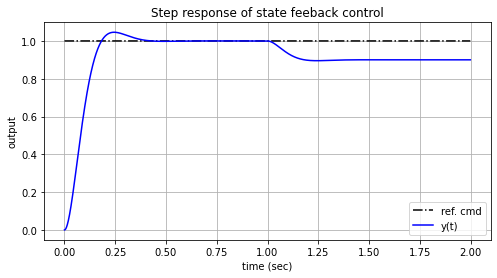

In [14]:
tvec = np.arange(0,2,0.001)
midpts = int(len(tvec)/2)
dist_level = 0.1
r = np.ones(tvec.shape)
rc = ffgain*np.ones(tvec.shape)
d = dist_level*ffgain*np.ones(tvec.shape)
d[:midpts] = 0
u = rc - d
t, y = ctl.forced_response(Tss, tvec, u)
plt.figure(figsize=(8,4))
plt.plot(tvec,r,'k-.',tvec,y,'b-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(["ref. cmd","y(t)"])
plt.title('Step response of state feeback control')
plt.show()

<p /><b>Example 2: </b>From the PID example discussed earlier, we show the advantage of integral term in eliminating 
the steady-state error. This principle can be applied to the state feedback scheme by augmenting an integrator as 
shown by the simulation diagram in Figure 5. There exist some systematic procedure to augment an integrator and design
all gains simultaneously, but that means the second-order relationship in the previous example is no longer 
applicable. So in this example we still use the pole-placement for second-order system as before, and then adjust 
the integral gain afterwards to achieve the desired response.

<p align="center">
<img src="https://drive.google.com/uc?id=1wIUhJGgMMsTe75qYS76ufcDUxTf99-m-" width=600 alt="Figure 5"/>
</p>
<div align="center"><b>Figure 5 Xcos simulation model for the state feedback with integrator control</b></div>

<p />Notice that the integrator replaces the DC gain compensation in Figure 1 to correct the response to the target 
steady-state value. Using the same state feedback gains results in slower transient response than Figure 4, 
so we redesign the pole-placement step by increasing $\omega_n$   to 40 rad/s.

In [15]:
zeta = 0.7
wn = 40
lamda_s = s**2 + 2*zeta*wn*s+wn**2
desired_poles = ctl.zero(lamda_s) # poles are roots of characteristic polynomial
print(desired_poles)

[-28.+28.56571371j -28.-28.56571371j]


This yields a new pair of state feedback gains.

In [16]:
K = ctl.acker(A, B, desired_poles)
print(K)

[[16000.    559.9]]


and the feedforward gain

In [17]:
Tss = ctl.ss(A-B@K, B, C, D)
ffgain=1/ctl.dcgain(Tss)
print(ffgain)

16000.0


is applied as compensation to the disturbance input to yield the same level  as in previous example; 
i.e., $d = 0.1$. By experimenting with the integral gain, we select $K_i = 200000$ , which gives the response as 
in Figure 6. The rise time and overshoot satisfy the specifications, while the system recovers to the desired value 
after the disturbance is applied at t = 1 sec. 

<p align="center">
<img src="https://drive.google.com/uc?id=1G7I8jsn3zJL_Gnl6PzH7RLoIjexv6QYA" width=450 alt="Figure 6"/>
</p>
<div align="center"><b>Figure 6 responses from the Xcos model in Figure 5</b></div>

To simulate this using Python control system library, the integrator have to be augmented to the state-space 
representation. From a general state feedback with integrator diagram in Figure 7, it is straightforward to show 
that the open-loop system is described by

\begin{equation} 
\left[ \begin{array}{c}
\dot{x} \\
\dot{w} 
\end{array}  \right] = 
\left[ \begin{array} {cc}
A & 0 \\
c & 0
\end{array} \right]
\left[ \begin{array}{c}
x \\
w
\end{array} \right] + 
\left[ \begin{array}{c}
b \\
0 
\end{array} \right] (u + d) + 
\left[ \begin{array}{c}
0 \\
-1 
\end{array} \right] r
\end{equation}

<div align="right">(13)</div>

<p align="center">
<img src="https://drive.google.com/uc?id=1YzlfVXnCv_luVi8uOagtp779hQA4sekS" width=450 alt="Figure 7"/>
</p>
<div align="center"><b>Figure 7 general block diagram of state feedback with integrator control</b></div>

Applying the control law

$$
u = -Kx -k_iw
$$

<div align="right">(14)</div>

results in the closed-loop system

\begin{equation} 
\left[ \begin{array}{c}
\dot{x} \\
\dot{w} 
\end{array}  \right] = 
\left[ \begin{array} {cc}
A-bK & -bk_i \\
c & 0
\end{array} \right]
\left[ \begin{array}{c}
x \\
w
\end{array} \right] + 
\left[ \begin{array}{c}
b \\
0 
\end{array} \right] d + 
\left[ \begin{array}{c}
0 \\
-1 
\end{array} \right] r
\end{equation}

<div align="right">(15)</div>

Create this system and do the simulation.

In [18]:
Ki = 200000
A_a = np.hstack((A-B@K, -Ki*B))
C_a = np.hstack((C,[[0]]))
A_a = np.vstack((A_a,C_a))
A_a
B_d = np.vstack((B,0))
B_r = np.vstack((np.zeros(B.shape),-1))
B_a = np.hstack((B_d,B_r))
D_a = np.zeros((1,2))
Tss_a = ctl.ss(A_a, B_a, C_a,D_a) #  two-inputs one-output closed-loop system

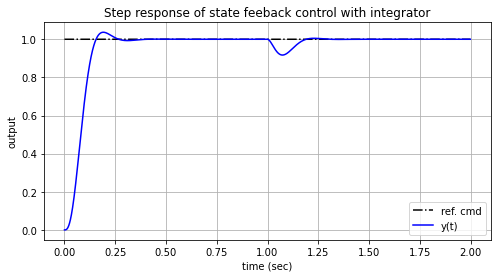

In [19]:
tvec = np.arange(0,2,0.001)
midpts = int(len(tvec)/2)
dist_level = 0.1
r = np.ones(tvec.shape)
d = -dist_level*ffgain*np.ones(tvec.shape)
d[:midpts] = 0
u = np.vstack((d,r))
t, y = ctl.forced_response(Tss_a, tvec, u)
plt.figure(figsize=(8,4))
plt.plot(tvec,r,'k-.',tvec,y.T,'b-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(["ref. cmd","y(t)"])
plt.title('Step response of state feeback control with integrator')
plt.show()

<h3>Summary</h3>
<p />In this module, we discuss state-space representation, using the robot joint driven by DC motor model as an 
example. The two state variables are the joint position and velocity, which are measurable in a real application. 
Hence the state feedback design scheme is suitable for this system. Joint position is normally obtained from an 
encoder using hardware or software readouts. Joint velocity may be measured via a tachometer, or obtained indirectly 
by counting encoder pulses per known time period. Finally, we show how to append an integrator to a state feedback 
design to eliminate steady-state error.  

<h3>References</h3>
<ol>
<li>V.Toochinda. 
<a href="http://dewninja.blogspot.com/p/robot-analysis-and-control-with-scilab.html" target=_blank>
Robot Analysis and Control with Scilab and RTSX</a>. Mushin Dynamics, 2014. </li>
</ol>

<b>Last update : </b> October 25, 2022
    
Update list :
<ul>
<li />October 25, 2022:
    <ul>
    <li />Remove <code>!pip install slycot</code>
    </ul>  
<li />May 3, 2021 : 
    <ul>    
    <li />change forced_response() format to control v 0.9.0
    <li />fix plot cmd in last cell to plt.plot(tvec,r,'k-.',tvec,y.T,'b-')
    </ul>
</ul>

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja<br>Copyright 2021</div>